In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
torch.manual_seed(42)
import numpy as np
from collections import defaultdict
from autograd_lib import autograd_lib


from torch.utils.data import DataLoader, TensorDataset

In [3]:
import os

result_folder = "finalResults"

if not os.path.exists(result_folder):
    os.mkdir(result_folder)

In [4]:
Y_func = lambda x : (torch.sin(5*np.pi*x)) /(5*np.pi*x) 
num_of_rows = 300
X= torch.unsqueeze(torch.linspace(-1,1,num_of_rows),dim=1)
Y = Y_func(X)
dataset = TensorDataset(X,Y)
data_loader = DataLoader(dataset,1,shuffle=True)

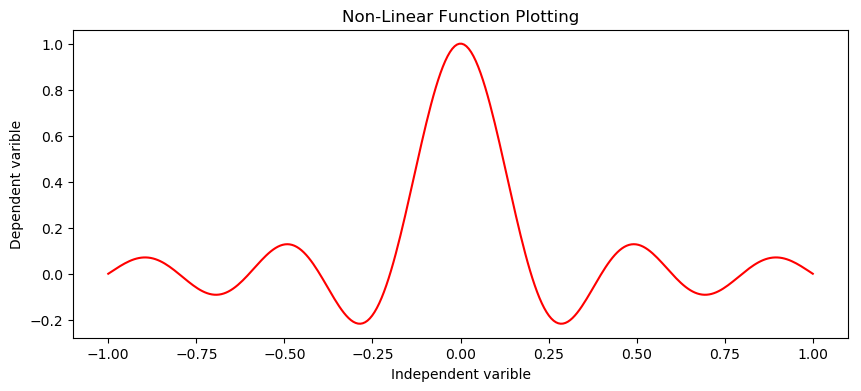

In [5]:
plt.figure(figsize=(10,4))
plt.plot(X, Y, color = "red")
plt.title('Non-Linear Function Plotting')
plt.xlabel('Independent varible')
plt.ylabel('Dependent varible')
plt.savefig(result_folder+'/func1_plot.png')

In [6]:
class MathRegressor(nn.Module):
    def __init__(self, num_hidden=128):
        super().__init__()
        self.regressor = nn.Sequential(
            nn.Linear(1, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, 1)
        )

    def forward(self, x):
        x = self.regressor(x)
        return x
    
    
    
    def training_step(self, batch,loss_fn):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = loss_fn(out, targets)    # Calculate loss
        return loss
    
    def validation_step(self, batch,loss_fn):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = loss_fn(out, targets)    # Calculate loss
        return {'val_loss': loss.detach()}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def train_step(self, batch,loss_fn):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = loss_fn(out, targets)    # Calculate loss
        return {'train_loss': loss.detach()}
    
    def train_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'train_loss': epoch_loss.item()}
    
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))
    
    

In [7]:
# class MathRegressor(nn.Module):
#     def __init__(self, num_hidden=128):
#         super().__init__()
#         self.regressor = nn.Sequential(
#             nn.Linear(1, 10),
#             nn.ReLU(),
#             nn.Linear(10, 18),
#             nn.ReLU(),
#             nn.Linear(18, 15),
#             nn.ReLU(),
#             nn.Linear(15, 4),
#             nn.ReLU(),
#             nn.Linear(4,1),
#         )

#     def forward(self, x):
#         x = self.regressor(x)
#         return x
    
    
#     def training_step(self, batch,loss_fn):
#         inputs, targets = batch 
#         out = self(inputs)                 # Generate predictions
#         loss = loss_fn(out, targets)    # Calculate loss
#         return loss
    
#     def validation_step(self, batch,loss_fn):
#         inputs, targets = batch 
#         out = self(inputs)                 # Generate predictions
#         loss = loss_fn(out, targets)    # Calculate loss
#         return {'val_loss': loss.detach()}
    
#     def validation_epoch_end(self, outputs):
#         batch_losses = [x['val_loss'] for x in outputs]
#         epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
#         return {'val_loss': epoch_loss.item()}
    
#     def train_step(self, batch,loss_fn):
#         inputs, targets = batch 
#         out = self(inputs)                 # Generate predictions
#         loss = loss_fn(out, targets)    # Calculate loss
#         return {'train_loss': loss.detach()}
    
#     def train_epoch_end(self, outputs):
#         batch_losses = [x['train_loss'] for x in outputs]
#         epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
#         return {'train_loss': epoch_loss.item()}
    
    
#     def epoch_end(self, epoch, result):
#         print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))
    
    

In [8]:
def compute_gradient_norm(model, criterion, train, target):
    model.train()
    model.zero_grad()
    output = model(train)
    loss = criterion(output, target)
    loss.backward()

    grads = []
    for p in model.regressor.children():
        if isinstance(p, nn.Linear):
            param_norm = p.weight.grad.norm(2).item()
            grads.append(param_norm)

    grad_mean = np.mean(grads) 

    return grad_mean

def save_activations(layer, A, _):
    activations[layer] = A

def compute_hess(layer, _, B):
    A = activations[layer]
    BA = torch.einsum('nl,ni->nli', B, A) 
    hess[layer] += torch.einsum('nli,nkj->likj', BA, BA)
    
def compute_minimum_ratio(model, criterion, train, target):
    model.zero_grad()
    
    with autograd_lib.module_hook(save_activations):
        output = model(train)
        loss = criterion(output, target)

    with autograd_lib.module_hook(compute_hess):
        autograd_lib.backward_hessian(output, loss='LeastSquares')

    layer_hess = list(hess.values())
    minimum_ratio = []

    for h in layer_hess:
        size = h.shape[0] * h.shape[1]
        h = h.reshape(size, size)
        h_eig = torch.symeig(h).eigenvalues 
        num_greater = torch.sum(h_eig > 0).item()
        minimum_ratio.append(num_greater / len(h_eig))

    ratio_mean = np.mean(minimum_ratio) 

    return ratio_mean

In [9]:
def get_norm_minimal_ratio(model,criterion):
#     criterion = nn.MSELoss()

    gradient_norm = compute_gradient_norm(model, criterion, X, Y)
    minimum_ratio = compute_minimum_ratio(model, criterion, X, Y)

    print('gradient norm: {}, minimum ratio: {}'.format(gradient_norm, minimum_ratio))
    result = {}
    result["grad_norm"] = gradient_norm
    result["ratio"] = minimum_ratio
    
    return result

In [10]:
def evaluate(model,loss_fn, val_loader):
    outputs = [model.validation_step(batch,loss_fn) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def evaluate2(model,loss_fn, train_loader):
    outputs = [model.train_step(batch,loss_fn) for batch in train_loader]
    return model.train_epoch_end(outputs)

def get_grad_norm(model):
    grad_all=0.0
    grad =0
    
    for p in model.parameters():
        if p.grad is not None:
            grad = (p.grad.cpu().data.numpy()**2).sum()
            
        grad_all+=grad
        
    grad_norm=grad_all ** 0.5
    return grad_norm


def fit(epochs, lr, model, data_loader, criterion,opt_func):
    history = []
    comparing_epoch_loss =1000.0
    grad_norm_per_epoch={}
#     autograd_lib.register(model)
#     activations = defaultdict(int)
#     hess = defaultdict(float)
    
#     train_history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
#         grad_norm_per_epoch[epoch] = get_grad_norm(model)
        optimizer.zero_grad()   # clear gradients for next train
    
#         if epoch > 900 and epoch%100 ==0:
#             print("Comparing result:", (comparing_epoch_loss - result["val_loss"]))
#             if (comparing_epoch_loss - result["val_loss"])  < 0.000001:
# #                 print("Comparing result:", (comparing_epoch_loss - result["val_loss"]))
#                 break
#             comparing_epoch_loss=result["val_loss"]
        
        # Training Phase 
        prediction = model(X)
        loss = criterion(prediction, Y)     # must be (1. nn output, 2. target)
        loss.backward()         # backpropagation, compute gradients
        
        
        
#             grad_norm_per_epoch[epoch] = get_grad_norm(model)
        
        grad_norm_per_epoch[epoch] = get_norm_minimal_ratio(model,criterion)
        
        
        optimizer.step() 
        
            
            
#             if epoch %100 == 0:
#                 print("grad_norm is :", grad_norm_per_epoch[epoch])
#             if grad_norm_per_epoch[epoch] == 1e-3 :
#                 return history,grad_norm_per_epoch,model
        optimizer.zero_grad()
        # Validation phase
        result = evaluate(model,criterion, data_loader)
        model.epoch_end(epoch, result)
        history.append(result)
        
        if epoch == 900:
            comparing_epoch_loss= result["val_loss"]
        
#         res2 = evaluate2(model,train_loader)
#         train_history.append(res2)
    return history,grad_norm_per_epoch,model

In [22]:
m3 = MathRegressor()
CriterionLoss = nn.MSELoss()
epochs = 2000
losses = []
grad_norm_list=[]
optim = torch.optim.Adam(m3.parameters(), lr=0.02)

for i in range(epochs):
    i+=1
    # feed forwarding
    y_pred = m3.forward(X)
    
    # calculate loss
    tloss = CriterionLoss(y_pred, Y)
    losses.append(tloss)
    
    optim.zero_grad()
    tloss.backward()
    
    optim.step()
    
    # Get gradient norm (From slides)
    grad_all = 0.0
    for p in m3.parameters():
        grad = 0.0
        if p.grad is not None:
            grad = (p.grad.cpu().data.numpy() ** 2).sum()
        grad_all += grad
    grad_norm = grad_all ** 0.5
    grad_norm_list.append(grad_norm)

losses=torch.tensor(losses)

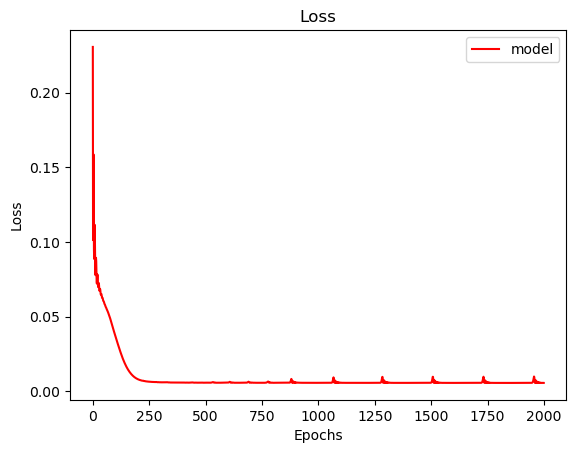

In [20]:
plt.plot(range(epochs), losses.numpy(), 'r', label='model')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

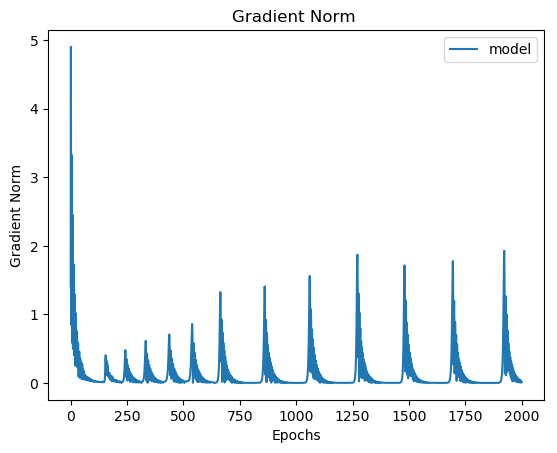

In [23]:
#Gradient norm to iterations
plt.plot(range(epochs), grad_norm_list,label='model')
plt.title("Gradient Norm ")
plt.xlabel("Epochs")
plt.ylabel("Gradient Norm")
plt.legend(loc="upper right")
plt.show()

In [18]:

# initial Parameters
num_of_rows = 300
lr = 0.0004
gamma_lr_scheduler = 0.1 
weight_decay = 1e-4
criterion = nn.MSELoss()
optimizer = torch.optim.Adam
num_epochs =2500
criterion_name = "MSE_LOSS_"
optimizer_name = "ADAM_opt"
filename = criterion_name+ optimizer_name+".png"
grad_norm_name = "_grad_norm_name1_2.png"
result_folder_name = "result3/"

In [47]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam
num_epochs =2000
criterion_name = "MSE_LOSS_"
optimizer_name = "ADAM_opt"
input_size=1
output_size=1
model= MathRegressor()

In [48]:
autograd_lib.register(model)
activations = defaultdict(int)
hess = defaultdict(float)
           

In [49]:
result_1 = evaluate(model,criterion,data_loader)
result_1

{'val_loss': 0.24811480939388275}

In [50]:
filename = criterion_name+ optimizer_name+".png"

In [51]:
train,target = X,Y

In [ ]:
history_1,grad_norm_1,model_1  = fit(num_epochs, lr, model_1, data_loader, criterion,optimizer)

gradient norm: 6.794032394886017, minimum ratio: 0.6484375
Epoch [0], val_loss: 2.5906
gradient norm: 6.8550320863723755, minimum ratio: 0.671875
Epoch [1], val_loss: 2.6329
gradient norm: 6.916284471750259, minimum ratio: 0.66015625
Epoch [2], val_loss: 2.6757
gradient norm: 6.977556988596916, minimum ratio: 0.66015625
Epoch [3], val_loss: 2.7188
gradient norm: 7.038907676935196, minimum ratio: 0.65625
Epoch [4], val_loss: 2.7623
gradient norm: 7.100486725568771, minimum ratio: 0.66796875
Epoch [5], val_loss: 2.8062
gradient norm: 7.162134662270546, minimum ratio: 0.65234375
Epoch [6], val_loss: 2.8506
gradient norm: 7.223933607339859, minimum ratio: 0.68359375
Epoch [7], val_loss: 2.8953
gradient norm: 7.285853073000908, minimum ratio: 0.65625
Epoch [8], val_loss: 2.9404
gradient norm: 7.348037227988243, minimum ratio: 0.671875
Epoch [9], val_loss: 2.9859
gradient norm: 7.4102038741111755, minimum ratio: 0.6640625
Epoch [10], val_loss: 3.0319
gradient norm: 7.472532317042351, minimum

Epoch [93], val_loss: 8.5308
gradient norm: 13.365202069282532, minimum ratio: 0.6640625
Epoch [94], val_loss: 8.6213
gradient norm: 13.446912169456482, minimum ratio: 0.6640625
Epoch [95], val_loss: 8.7124
gradient norm: 13.528890669345856, minimum ratio: 0.67578125
Epoch [96], val_loss: 8.8042
gradient norm: 13.611084163188934, minimum ratio: 0.6796875
Epoch [97], val_loss: 8.8967
gradient norm: 13.69374230504036, minimum ratio: 0.640625
Epoch [98], val_loss: 8.9899
gradient norm: 13.777151316404343, minimum ratio: 0.67578125
Epoch [99], val_loss: 9.0838
gradient norm: 13.860296547412872, minimum ratio: 0.66796875
Epoch [100], val_loss: 9.1784
gradient norm: 13.94383955001831, minimum ratio: 0.640625
Epoch [101], val_loss: 9.2737
gradient norm: 14.027676314115524, minimum ratio: 0.66015625
Epoch [102], val_loss: 9.3698
gradient norm: 14.111709475517273, minimum ratio: 0.671875
Epoch [103], val_loss: 9.4665
gradient norm: 14.19635733962059, minimum ratio: 0.66796875
Epoch [104], val_l

Epoch [184], val_loss: 20.1036
gradient norm: 22.204712212085724, minimum ratio: 0.6796875
Epoch [185], val_loss: 20.2754
gradient norm: 22.31958943605423, minimum ratio: 0.6640625
Epoch [186], val_loss: 20.4484
gradient norm: 22.43469524383545, minimum ratio: 0.66796875
Epoch [187], val_loss: 20.6225
gradient norm: 22.550527095794678, minimum ratio: 0.64453125
Epoch [188], val_loss: 20.7978
gradient norm: 22.666279196739197, minimum ratio: 0.65625
Epoch [189], val_loss: 20.9742
gradient norm: 22.782846093177795, minimum ratio: 0.6640625
Epoch [190], val_loss: 21.1519
gradient norm: 22.899579346179962, minimum ratio: 0.66015625
Epoch [191], val_loss: 21.3306
gradient norm: 23.017061948776245, minimum ratio: 0.66796875
Epoch [192], val_loss: 21.5106
gradient norm: 23.134754061698914, minimum ratio: 0.6953125
Epoch [193], val_loss: 21.6917
gradient norm: 23.253042340278625, minimum ratio: 0.65625
Epoch [194], val_loss: 21.8741
gradient norm: 23.371673464775085, minimum ratio: 0.6640625
E

In [ ]:
grad_norm_1

In [40]:
val_losses_1 = [r['val_loss'] for r in history_1]

In [41]:
len(val_losses_1)

100

In [44]:
minimal_ratio_eps = [i['ratio'] for i in grad_norm_1.values() ]

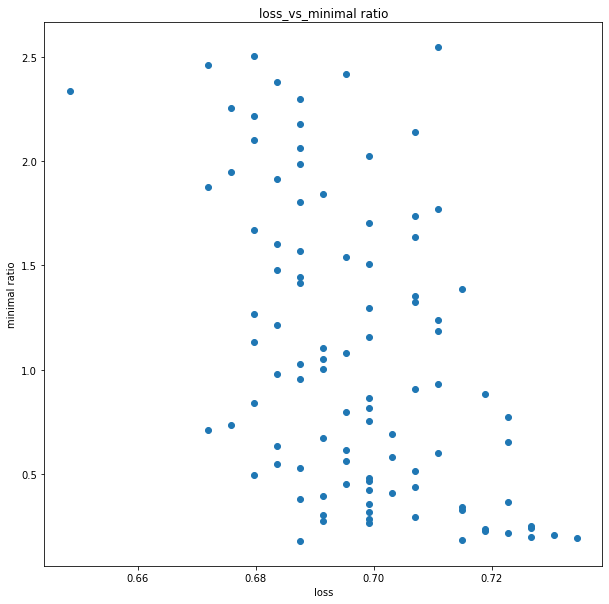

In [46]:
plt.figure(figsize=(10,10))
plt.scatter(minimal_ratio_eps,val_losses_1)
plt.xlabel('loss')
plt.ylabel('minimal ratio')
plt.title('loss_vs_minimal ratio');
plt.plot()
plt.savefig("loss_vs_minimal ratio.png")